# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [1]:
# Uncomment and run these in Colab
%tensorflow_version 1.x
# !pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import plot_model
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ROLLNUMBER = 20100136
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2500
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR = ''
BASE_DIR = '/content/drive/My Drive/DL P5'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

In [4]:
cd '/content/drive/My Drive/DL P5'

/content/drive/My Drive/DL P5


## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = 'Apple/Train/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<br>
![DCGAN Discriminator](DCGAN_disc.png)
<br>

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [0]:
def build_discriminator():
    x1_in1 = Input(shape=(64,64,3))
    x2 = Conv2D(64,(4,4),padding='same',strides=2,  input_shape=(64,64,3), use_bias=False)(x1_in1)
    x3 = LeakyReLU(alpha=0.2)(x2)
    x4 = Conv2D(128,(4,4),padding='same',strides=2,  input_shape=(32,32,64), use_bias=False)(x3)
    x5 = BatchNormalization()(x4)
    x6 = LeakyReLU(alpha=0.2)(x5)
    x7 = Conv2D(256,(4,4),padding='same',strides=2, input_shape=(16,16,128), use_bias=False)(x6)
    x8 = BatchNormalization()(x7)
    x9 = LeakyReLU(alpha=0.2)(x8)
    x10 = Conv2D(512,(4,4),padding='same',strides=2, input_shape=(8,8,256), use_bias=False)(x9)
    x11 = BatchNormalization()(x10)
    x12 = LeakyReLU(alpha=0.2)(x11)
    x13 = Conv2D(1,(3,3),padding='same', input_shape=(4,4,512), use_bias=False)(x12)
    x14 = Flatten()(x13)
    x_o = Dense(1, activation='sigmoid')(x14)
    model = Model(inputs=x1_in1,outputs=x_o)

    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


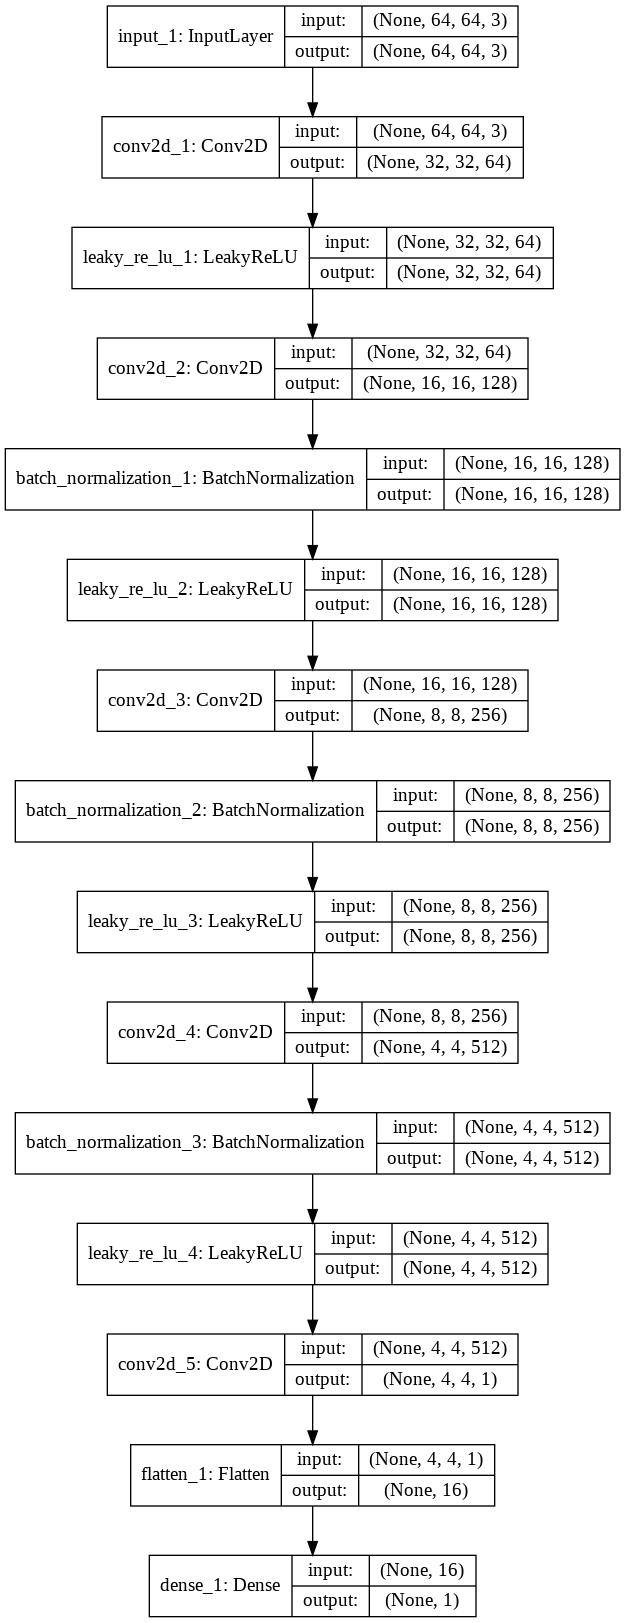

In [0]:
d = build_discriminator()
model_name = 'discriminator'
plot_model(d, model_name+'.png',show_shapes=True)

### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<br>
![DCGAN Generator](DCGAN_gen.png)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [0]:
def build_generator():
    x1_in1 = Input(shape=(100,))
    x_d = Dense(16384)(x1_in1)
    x2 = Reshape((4,4,1024))(x_d)
    x3 = Conv2DTranspose(512,(5,5),padding='same',strides=2, activation = 'relu', input_shape=(4,4,1024), use_bias=False)(x2)
    x4 = Conv2DTranspose(256,(5,5),padding='same',strides=2, activation = 'relu', input_shape=(8,8,512), use_bias=False)(x3)
    x5 = Conv2DTranspose(128,(5,5),padding='same',strides=2, activation = 'relu', input_shape=(16,16,256), use_bias=False)(x4)
    x_o = Conv2DTranspose(3,(5,5),padding='same',strides=2, activation = 'tanh', input_shape=(32,32,128), use_bias=False)(x5)
    
    model = Model(inputs=x1_in1,outputs=x_o)

    return model

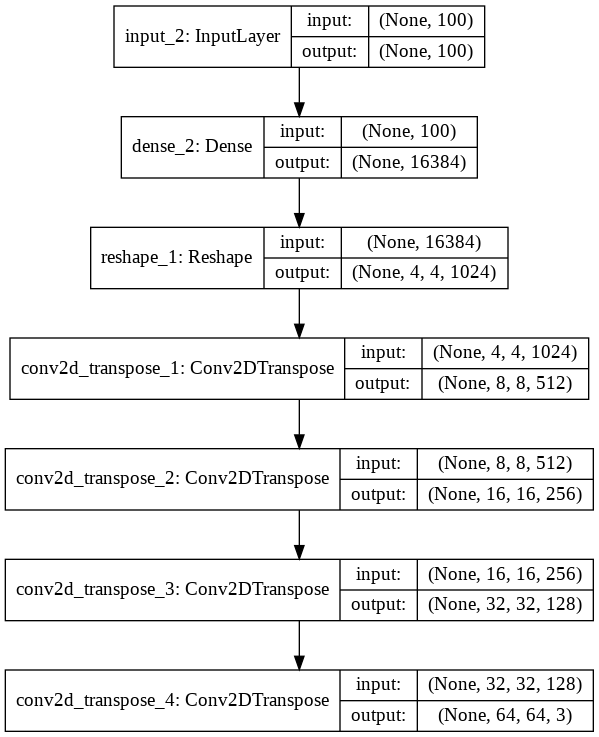

In [0]:
g = build_generator()
model_name = 'generator'
plot_model(g, model_name+'.png',show_shapes=True)

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [0]:
def build_gan(gen,disc): 
  
  disc.trainable = False
  gan = Sequential()
  gan.add(gen)
  gan.add(disc)

  optimizer = Adam(0.0002,0.5)
  gan.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return gan

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


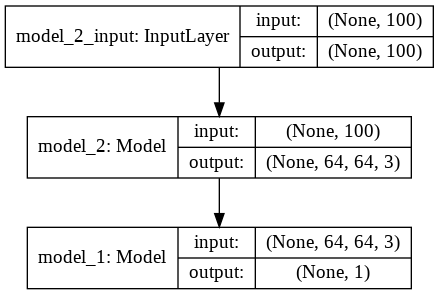

In [0]:
gan = build_gan(g,d)
model_name = 'gan'
plot_model(gan, model_name+'.png',show_shapes=True)

Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [0]:
def save_samples(generated_images,step,save_at="samples/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here  
    optimizer = Adam(0.002)
    gen = build_generator()
    gen.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    disc = build_discriminator()
    disc.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    gan = build_gan(gen,disc)

    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    true = np.ones((BATCH_SIZE, 1))
    fake = np.zeros((BATCH_SIZE, 1))
   

    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            noise = sample_noise()
            imgs = X_train[index:index+BATCH_SIZE]
            generated_imgs = gen.predict(noise)
            disc.trainable = True
            dr = disc.train_on_batch(imgs, true)
            df = disc.train_on_batch(generated_imgs, fake)
            disc_loss = df[0]
            epoch_disc_loss.append(disc_loss)

            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch
            disc.trainable = False
            noise = sample_noise()
            gans_train = gan.train_on_batch(noise,true)
            gen_loss = gans_train[0]
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
            if not (e % intervals):
                save_samples(generated_imgs,e) 
        if not (e%intervals):
            # Save weights here
            disc.save_weights(os.path.join(BASE_DIR,'discriminator'),True)
            gen.save_weights(os.path.join(BASE_DIR,'generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell




In [0]:
disc_loss, gen_loss =  gan_training_loop(intervals=200)

Streaming output truncated to the last 5000 lines.
Epoch: 1 | Discriminator Loss: 10.882996 | Generator Loss: 20.262981
5/5 [==============================] - 5s 1s/step
Epoch: 2 | Discriminator Loss: 0.819399 | Generator Loss: 7.874692
5/5 [==============================] - 5s 1s/step
Epoch: 3 | Discriminator Loss: 0.184762 | Generator Loss: 11.717008
5/5 [==============================] - 5s 1s/step
Epoch: 4 | Discriminator Loss: 0.125635 | Generator Loss: 10.776344
5/5 [==============================] - 5s 1s/step
Epoch: 5 | Discriminator Loss: 0.046592 | Generator Loss: 9.780368
5/5 [==============================] - 5s 1s/step
Epoch: 6 | Discriminator Loss: 0.011929 | Generator Loss: 10.052343
5/5 [==============================] - 5s 1s/step
Epoch: 7 | Discriminator Loss: 0.010423 | Generator Loss: 8.775934
5/5 [==============================] - 5s 1s/step
Epoch: 8 | Discriminator Loss: 0.005678 | Generator Loss: 7.822099
5/5 [==============================] - 5s 1s/step
Epoch: 9

### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

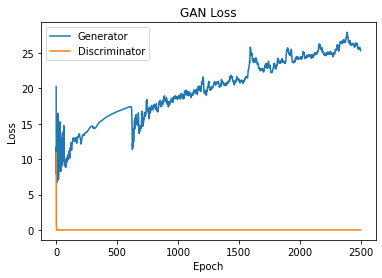

In [0]:
plot_loss(gen_loss,disc_loss)

The MiniMax play between the two players, discriminator and generator, should be such that the discriminator loss is maximised and the generator loss is minimized. However, in this current training, the gan does not work effectively since the discriminator wins early on and the model is not trained effectively. The discriminator'loss decreases and the generator's loss increases.

**FAILURE MODE:**

The discriminator overpowers the generator. Within a few epochs, the discriminator loss goes close to 0. The discriminator is able to correctly discriminate between fake and real images where as the generator is failing to learn and in turn, fails to fool the discriminator. The generator also produces low-quality images that are easily identified as fake by the discriminator.
This might be because hard labels(1 or 0) nearly killed all learning early on, leading the discriminator to approach 0 loss very rapidly.

**Generation of 5 Random Images**

In [0]:
 noise = np.reshape(np.random.normal(0.0, 1.0, NOISE_DIM * 5),(5,NOISE_DIM))

In [0]:
g.load_weights('generator')
generated_imgs = g.predict(noise)

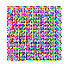

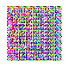

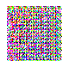

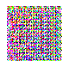

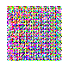

In [0]:
for i in generated_imgs:
    img = k_image.array_to_img(i)
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img)

## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [0]:
Initializer = RandomNormal(0,0.02)

In [0]:
def build_discriminator():
    x1_in1 = Input(shape=(64,64,3))
    x2 = Conv2D(64,(4,4),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(64,64,3), use_bias=False)(x1_in1)
    x3 = LeakyReLU(alpha=0.2)(x2)
    x4 = Conv2D(128,(4,4),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(32,32,64), use_bias=False)(x3)
    x5 = BatchNormalization()(x4)
    x6 = LeakyReLU(alpha=0.2)(x5)
    x7 = Conv2D(256,(4,4),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(16,16,128), use_bias=False)(x6)
    x8 = BatchNormalization()(x7)
    x9 = LeakyReLU(alpha=0.2)(x8)
    x10 = Conv2D(512,(4,4),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(8,8,256), use_bias=False)(x9)
    x11 = BatchNormalization()(x10)
    x12 = LeakyReLU(alpha=0.2)(x11)
    x13 = Conv2D(1,(3,3),padding='same',kernel_initializer= Initializer, input_shape=(4,4,512), use_bias=False)(x12)
    x14 = Flatten()(x13)
    x_o = Dense(1, activation='sigmoid')(x14)
    model = Model(inputs=x1_in1,outputs=x_o)

    return model

In [0]:
def build_generator():
    x1_in1 = Input(shape=(100,))
    x_d = Dense(16384)(x1_in1)
    x2 = Reshape((4,4,1024))(x_d)
    x3 = Conv2DTranspose(512,(5,5),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(4,4,1024), use_bias=False)(x2)
    x4 = LeakyReLU(alpha=0.2)(x3)
    x5 = Conv2DTranspose(256,(5,5),padding='same',strides=2,kernel_initializer= Initializer,  input_shape=(8,8,512), use_bias=False)(x3)
    x6 = LeakyReLU(alpha=0.2)(x5)
    x7 = Conv2DTranspose(128,(5,5),padding='same',strides=2,kernel_initializer= Initializer, input_shape=(16,16,256), use_bias=False)(x6)
    x8 = LeakyReLU(alpha=0.2)(x7)
    x_o = Conv2DTranspose(3,(5,5),padding='same',strides=2,kernel_initializer= Initializer, activation = 'tanh', input_shape=(32,32,128), use_bias=False)(x8)
 
    
    model = Model(inputs=x1_in1,outputs=x_o)

    return model
    

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [0]:
def normalize(images):
  return (images - 127.5)/127.5

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [0]:
def sample_noise():
     return np.reshape(np.random.normal(0.0, 1.0, NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [0]:
def smooth_real_labels(y):
  return np.random.uniform(low = 0.7, high = 1.2, size = (y,))

#### Fake Label Smoothing

In [0]:
def smooth_fake_labels(y):
     return np.random.uniform(low = 0.0, high = 0.3, size = (y,))

We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    optimizer = Adam(0.0002,0.5)
    gen = build_generator()
    gen.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    disc = build_discriminator()
    disc.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    gan = build_gan(gen,disc)
    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    EPOCHS = 1800
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for i,index in enumerate(indices):
            # Write your code here
           
            noise = sample_noise()
            imgs = X_train[index:index+BATCH_SIZE]
            imgs = normalize(imgs)
            generated_imgs = gen.predict(noise)
            true = smooth_real_labels(BATCH_SIZE)
            fake = smooth_fake_labels(BATCH_SIZE)

            if not (e % intervals):
                save_samples(generated_imgs,e)

            disc.trainable = True
            dr = disc.train_on_batch(imgs, true)
            df = disc.train_on_batch(generated_imgs, fake)
            disc_loss =  0.5 * np.add(dr[0], df[0])
            epoch_disc_loss.append(disc_loss)
            disc.trainable = False   
            # If you are training the discriminator in two updates, uncomment this
            # disc_loss = (disc_fake_loss + disc_real_loss) * 0.5
            noise = sample_noise()
            true_g = smooth_real_labels(BATCH_SIZE)
            gan_train = gan.train_on_batch(noise,true_g)
            gen_loss = gan_train[0]
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            
            progress_bar.update(i+1)
        if not (e%intervals):
            disc.save_weights(os.path.join(BASE_DIR,'discriminator1'),True)
            gen.save_weights(os.path.join(BASE_DIR,'generator1'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
disc_loss, gen_loss =  gan_training_loop(intervals=200)

5/5 [==============================] - 6s 1s/step
Epoch: 1 | Discriminator Loss: 0.769772 | Generator Loss: 3.572625
5/5 [==============================] - 1s 229ms/step
Epoch: 2 | Discriminator Loss: 0.649939 | Generator Loss: 3.915311
5/5 [==============================] - 1s 227ms/step
Epoch: 3 | Discriminator Loss: 0.604809 | Generator Loss: 3.681878
5/5 [==============================] - 1s 227ms/step
Epoch: 4 | Discriminator Loss: 0.428863 | Generator Loss: 2.933517
5/5 [==============================] - 1s 228ms/step
Epoch: 5 | Discriminator Loss: 0.445108 | Generator Loss: 3.161291
5/5 [==============================] - 1s 230ms/step
Epoch: 6 | Discriminator Loss: 0.792920 | Generator Loss: 6.105994
5/5 [==============================] - 1s 227ms/step
Epoch: 7 | Discriminator Loss: 0.651882 | Generator Loss: 4.319074
5/5 [==============================] - 1s 227ms/step
Epoch: 8 | Discriminator Loss: 0.531849 | Generator Loss: 3.682676
5/5 [==============================] - 1s 2

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images

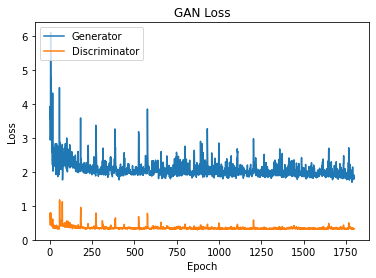

In [0]:
plot_loss(gen_loss,disc_loss)

 **Generation of 5 Random Images**

In [0]:
noise = np.reshape(np.random.normal(0.0, 1.0, NOISE_DIM * 5),(5,NOISE_DIM))

In [0]:
g = build_generator()
g.load_weights('generator1')
generated_imgs = g.predict(noise)

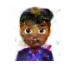

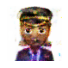

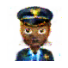

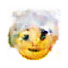

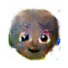

In [0]:
for i in generated_imgs:
    img = k_image.array_to_img(i)
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img)

With new changes, the generator was able to learn effectively which results in high quality fake images being produced by the generator. The loss is unstable in the beginning but remains almost stable after the 500th epoch with a little variance. The average discriminator loss is about 0.3-0.4 whereas the average generator loss fluctuates between 2-3 as the number of epochs increases. 

*Mode collapse* is also visible in the saved samples since the generator generates a limited diversity of samples, or even the same sample, regardless of the input. This might be because the goal of the generator is to fool the discriminator by causing it to assign the generated sample the highest probability of being real as possible.

The new changes that were introduced into this gan model were the following:

*  **A learning rate of 0.002 with a momentum of 0.5** => *The best practice for training GANS is to use the Adam version of stochastic gradient descent with the learning rate of 0.0002 and the beta1 momentum value of 0.5*
*   **Normalization of images between -1 and 1** => *This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.*
*   **Leaky Relu layers in the Generator** => *Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator.*
*   **Usage of Smooth labels**  => *As mentioned, smooth labels have a regularizing effect on training.*
*   **Gaussian weight Initialization** => *The model weights are initialized to small random variables. The best practice reported in the paper is to initialize all weights using a zero-centered Gaussian distribution with a standard deviation of 0.02.*
*   **Using Gaussian latent space** => *The latent space defines the shape and distribution of the input to the generator model used to generate new images. The DCGAN recommends sampling from a uniform distribution, meaning that the shape of the latent space is a hypercube.* 


## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    optimizer = Adam(0.0002,0.5)
    gen = build_generator()
    gen.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    disc = build_discriminator()
    disc.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    gan = build_gan(gen,disc)
    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    EPOCHS = 1200
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for i,index in enumerate(indices):
            # Write your code here
           
            noise = sample_noise()
            imgs = X_train[index:index+BATCH_SIZE]
            imgs = normalize(imgs)
            generated_imgs = gen.predict(noise)
            true = smooth_real_labels(BATCH_SIZE)
            fake = smooth_fake_labels(BATCH_SIZE)

            if not (e % intervals):
                save_samples(generated_imgs,e)

            disc.trainable = True
            dr = disc.train_on_batch(imgs, true)
            df = disc.train_on_batch(generated_imgs, fake)
            disc_loss =  0.5 * np.add(dr[0], df[0])
            epoch_disc_loss.append(disc_loss)
            disc.trainable = False   
            # If you are training the discriminator in two updates, uncomment this
            # disc_loss = (disc_fake_loss + disc_real_loss) * 0.5
            noise = sample_noise()
            true_g = smooth_real_labels(BATCH_SIZE)
            gan_train = gan.train_on_batch(noise,true_g)
            gen_loss = gan_train[0]
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            
            progress_bar.update(i+1)
        if not (e%intervals):
            disc.save_weights(os.path.join(BASE_DIR,'discriminator2'),True)
            gen.save_weights(os.path.join(BASE_DIR,'generator2'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [17]:
disc_loss, gen_loss =  gan_training_loop(intervals=200)


17/17 [==============================] - 16s 930ms/step
Epoch: 1 | Discriminator Loss: 0.655400 | Generator Loss: 3.806398
17/17 [==============================] - 4s 229ms/step
Epoch: 2 | Discriminator Loss: 0.716809 | Generator Loss: 5.069235
17/17 [==============================] - 4s 229ms/step
Epoch: 3 | Discriminator Loss: 0.769742 | Generator Loss: 4.328019
17/17 [==============================] - 4s 228ms/step
Epoch: 4 | Discriminator Loss: 0.443117 | Generator Loss: 2.669206
17/17 [==============================] - 4s 227ms/step
Epoch: 5 | Discriminator Loss: 0.417049 | Generator Loss: 2.761494
17/17 [==============================] - 4s 226ms/step
Epoch: 6 | Discriminator Loss: 0.420879 | Generator Loss: 2.899432
17/17 [==============================] - 4s 226ms/step
Epoch: 7 | Discriminator Loss: 0.363478 | Generator Loss: 2.253636
17/17 [==============================] - 4s 226ms/step
Epoch: 8 | Discriminator Loss: 0.374926 | Generator Loss: 2.400925
17/17 [===============

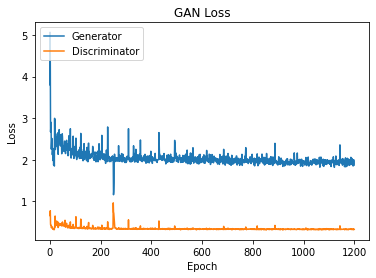

In [21]:
plot_loss(gen_loss,disc_loss)

**Generation of 5 Random Images**

In [0]:
noise = np.reshape(np.random.normal(0.0, 1.0, NOISE_DIM * 5),(5,NOISE_DIM))

In [0]:
g = build_generator()
g.load_weights('generator2')
generated_imgs = g.predict(noise)

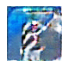

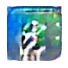

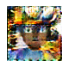

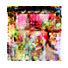

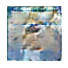

In [108]:
for i in generated_imgs:
    img = k_image.array_to_img(i)
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img)

For this,  the subset Train of the full emojis dataset was used for training the GAN. The results were similar to that of the filtered emojis dataset with the loss of the generator being stable between 2 and 3 and the loss of the discriminator fluctuating between 0.2 and 0.3. However, the variance increases with the bigger dataset. 
The problem of mode collapse exists which can be seen in the samples. The generated images have a low quality as compared to those of the filtered emojis dataset. This might be because they are so many variants of the images and learning is harder for the generator.